# MMLU Benchmark

Basic guide to running Massive Multitask Language Understanding (MMLU) benchmark using Llama models.

# Imports

In [1]:
import logging
import os
from pathlib import Path
from random import sample
from time import perf_counter_ns as timer

from IPython.display import display
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
from tqdm import tqdm

import llama_benchmarks as llb
from llama_benchmarks.models import llama
from llama_benchmarks.mmlu import Question, Questions, Answer, Answers, MMLULlamaGenerator

# Parameters

In [2]:
# Sample size
n_questions = 16

# Setup

In [3]:
# Switch to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

# Configure logger
logger = logging.getLogger(__name__)

# Path to datasets
datasets_path = Path(".build") / "datasets" 

In [4]:
def show_questions(questions: Questions):
    display(DataFrame(questions))

# MMLU Dataset

The Massive Multitask Language Understanding (MMLU) benchmark dataset from https://github.com/hendrycks/test contains 14,042 MCQs from 57 categories. Each question has 4 options A, B, C, and D and one correct answer. In addition, each category has 5 example questions designed for few-shot experiments.

In [5]:
mmlu_dataset_path = datasets_path / "mmlu"

# Load sample of questions from MMLU dataset
examples, questions = llb.mmlu.load_dataset(mmlu_dataset_path, n_questions=n_questions)
show_questions(sample(questions, k=3))

,category,question,A,B,C,D,answer
0,sociology,Which of the following policies did the New La...,setting and streaming pupils by ability,parental choice of school,supporting LEAs that appeared to be failing,state regulation and control of the curriculum,C
1,professional law,"After two men robbed a local bank, they left t...","inadmissible, because it violates the physicia...","admissible, because the technician overheard t...","admissible, because of the nature of the man's...","admissible, because the statement was not conf...",C
2,conceptual physics,The speed of sound in air depends on,frequency.,wavelength.,air temperature.,All of these.,C


# Prompting

We combine each question with the relevant examples to generate few-shot prompts. The prompt template is based on the one used by Hendrycks et al. (2021) and implemented at https://github.com/hendrycks/test.

In [6]:
prompt = llb.mmlu.generate_prompt(examples, sample(questions, k=1)[0], n_shots=2)
print(prompt)

The following are multiple choice questions (with answers) about high school mathematics.

Question: Simplify and write the result with a rational denominator: $$\sqrt{\sqrt[3]{\sqrt{\frac{1}{729}}}}$$

A) \frac{3\sqrt{3}}{3}
B) \frac{1}{3}
C) \sqrt{3}
D) \frac{\sqrt{3}}{3}

Answer: D

Question: Five thousand dollars compounded annually at an $x\%$ interest rate takes six years to double. At the same interest rate, how many years will it take $\$300$ to grow to $\$9600$?

A) 12
B) 1
C) 30
D) 5

Answer: C

Question: A relative maximum value of the function y = (ln x)/x is

A) 1
B) e
C) 2/e
D) 1/e

Answer: 


# Generating Answers

In [7]:
# Create a Llama 3.2 3B MMLU generator
generator = MMLULlamaGenerator(llama.config("Llama3.2-3B"))

In [8]:
start_time = timer()

answers = []
correct = 0
for answer in tqdm(generator(examples, questions), total=n_questions):
    answers.append(answer)
    if answer.correct:
        correct += 1

duration = timer() - start_time
print(f"Answering {n_questions} questions took {duration / 1000000000:0.3f}s")

  0%|                                                                                                                                                               | 0/16 [00:00<?, ?it/s]Top token id 16 is not in MMLU options dict_values([32, 33, 34, 35])
16 = 19.58460235595703, vs, tensor([10.9279,  7.5884,  6.2252,  9.5336], device='mps:0')
  6%|█████████▍                                                                                                                                             | 1/16 [00:00<00:09,  1.61it/s]Top token id 15 is not in MMLU options dict_values([32, 33, 34, 35])
15 = 18.97964859008789, vs, tensor([8.5567, 8.6281, 8.6632, 9.8178], device='mps:0')
 12%|██████████████████▉                                                                                                                                    | 2/16 [00:02<00:21,  1.54s/it]Top token id 16 is not in MMLU options dict_values([32, 33, 34, 35])
16 = 20.088703155517578, vs, tensor([10.0286,  9.4044,  9.

Answering 16 questions took 11.724s


In [9]:
# Calculate metrics
metrics = {
    "n": n_questions,
    "correct": correct,
    "accuracy": correct / n_questions,
    "rps": 1000000000 * n_questions / duration,
}

metrics

{'n': 16, 'correct': 8, 'accuracy': 0.5, 'rps': 1.3647031146868587}

In [10]:
generator.tokenizer.decode([18])

'3'

# Analyzing Answers

In [11]:
# Correct questions
correct_answers = tuple(a for a in answers if a.correct)
correct_questions = tuple(questions[a.qid] for a in correct_answers)

# Incorrect questions
incorrect_answers = tuple(a for a in answers if not a.correct)
incorrect_questions = tuple(questions[a.qid] for a in incorrect_answers)

## Uncertainty: Correct Answers

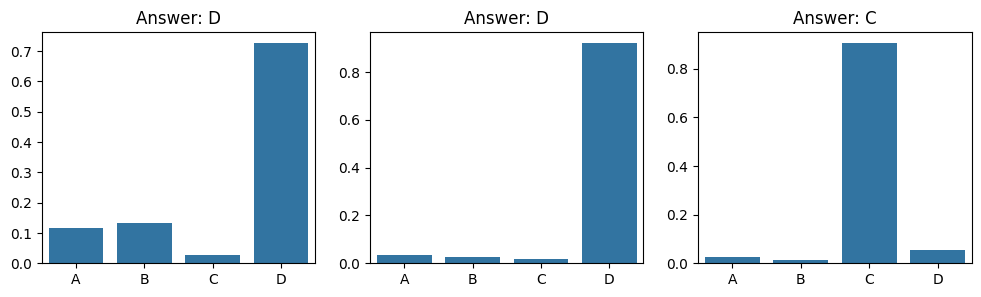

In [12]:
selected = sample(correct_answers, 3)

fig, axs = plt.subplots(ncols=len(selected), figsize=(12,3))
for i, answer in enumerate(selected):
    sns.barplot(data=answer.scores, ax=axs[i])
    axs[i].set_title(f"Answer: {answer.expected}")

## Uncertainty: Incorrect Answers

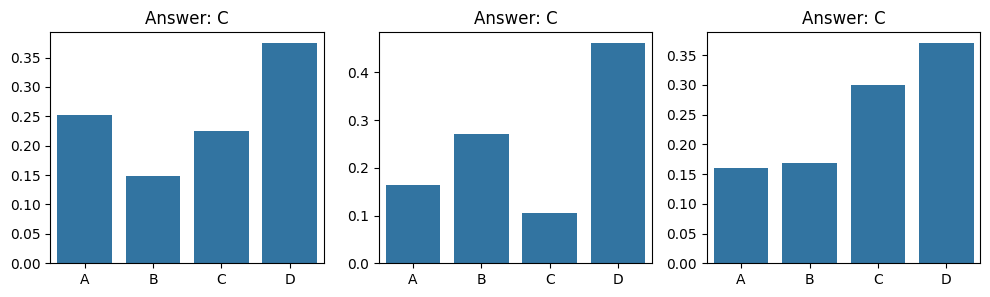

In [13]:
selected = sample(incorrect_answers, 3)

fig, axs = plt.subplots(ncols=len(selected), figsize=(12,3))
for i, answer in enumerate(selected):
    sns.barplot(data=answer.scores, ax=axs[i])
    axs[i].set_title(f"Answer: {answer.expected}")